# Sorted unit types

author: steeve.laquitaine@epfl.ch  

**methods**:
* We focus on single-units
* multi-units have not one type by definition.

**conclusion**:
* **strong sampling bias**: single-unit excitatory cADpyr from L5,6 then L2/3 and 4 are preferentially captured by all spike sorters. INH units are strongly undersampled.
* All tested spike sorters share the same sampling bias.

**next**:
* what is effect of this sampling bias on the circuit's information capacity (IC)?
    * contrast IC b/w random sampling vs. biased sampling.

### Setup

Setup `manifold` env

In [64]:
# SETUP PACKAGES 
%load_ext autoreload
%autoreload 2
import os
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
import spikeinterface as si
import numpy as np
from collections import Counter
import pandas as pd
from sklearn.decomposition import PCA # dimensionality reduction
from mftma.manifold_analysis_correlation import manifold_analysis_corr
import random
import seaborn as sns
from collections import defaultdict
import pickle
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 
from scipy.stats import kruskal  # stats
import scikit_posthocs as sp


# SET PROJECT PATH
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/preprint_2023"
os.chdir(PROJ_PATH)
from src.nodes import utils
from src.nodes.utils import get_config
from src.nodes.analysis.code import igeom
from src.nodes.metrics.quality import get_scores
from src.nodes.analysis.features import features as feat
from src.nodes.analysis.stats import stats

# SETUP CONFIG
data_conf, _ = get_config("silico_neuropixels", "stimulus").values()
GT = data_conf["sorting"]["simulation"]["ground_truth"]["full"]["output"]
REC = data_conf["probe_wiring"]["output"]
IGEOM = data_conf["analyses"]["neural_code"]["igeom"]
IGEOM_BY_Q = data_conf["analyses"]["neural_code"]["by_quality"]["igeom"]

# SORTINGS
K4 = data_conf["sorting"]["sorters"]["kilosort4"]["full"]["output"]
K3 = data_conf["sorting"]["sorters"]["kilosort3"]["full"]["output"]
K25 = data_conf["sorting"]["sorters"]["kilosort2_5"]["full"]["output"]
K2 = data_conf["sorting"]["sorters"]["kilosort2"]["full"]["output"]
KS = data_conf["sorting"]["sorters"]["kilosort"]["full"]["output"]
HS = data_conf["sorting"]["sorters"]["herdingspikes"]["full"]["output"]


# SETUP QUALITY PATH
quality_path = "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/preprint_2024/dataeng/0_silico/4_spikesorting_stimulus_test_neuropixels_8-1-24__8slc_80f_360r_50t_200ms_1_smallest_fiber_gids/0fcb7709-b1e9-4d84-b056-5801f20d55af/analysis/sorting_quality/sorting_quality_1h.csv"

# TASK DESIGN PARAMETERS
N_SIMS = 36 # number of simulation files
SELECT_PERIOD = False
DT = 1.3

# FIGURE SETTINGS
COLOR_VIVO = (0.7, 0.7, 0.7)
COLOR_SILI = (0.84, 0.27, 0.2)
COLOR_STIM = (0.6, 0.75, 0.1)
BOX_ASPECT = 1                  # square fig
plt.rcParams['figure.figsize'] = (2,1)
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 6
plt.rcParams['lines.linewidth'] = 0.5
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.major.width'] = 0.3
plt.rcParams['xtick.minor.size'] = 0.1
plt.rcParams['xtick.major.size'] = 1.5
plt.rcParams['ytick.major.size'] = 1.5
plt.rcParams['ytick.major.width'] = 0.3
legend_cfg = {"frameon": False, "handletextpad": 0.1}
savefig_cfg = {"transparent":True, "dpi": 300} 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2024-10-17 12:24:44,929 - root - utils.py - get_config - INFO - Reading experiment config.
2024-10-17 12:24:45,150 - root - utils.py - get_config - INFO - Reading experiment config. - done


### Custom functions

In [ ]:
def get_obs(count_g, count_oo):
    obs_df = pd.DataFrame()
    obs_df["good"] = count_g["count"].values
    obs_df["oo"] = count_oo["count"].values
    return obs_df

## (40s)Load datasets

In [42]:
# get sorted unit quality and bias classification
quality_df = pd.read_csv(quality_path)

# get true evoked data
SortingTrue = si.load_extractor(GT)
Recording = si.load_extractor(REC)
duration_secs = Recording.get_total_duration()
SFREQ = SortingTrue.get_sampling_frequency()

# get SortingExtractors
SortingK4 = si.load_extractor(K4)
SortingK3 = si.load_extractor(K3)
SortingK25 = si.load_extractor(K25)
SortingK2 = si.load_extractor(K2)
SortingKS = si.load_extractor(KS)
SortingHS = si.load_extractor(HS)

In [43]:
# create dataset of sorted unit types (derived from their best matched ground truth)
df_k4 = feat.get_feature_data_for("KS4", SortingK4, SortingTrue, quality_path, DT)
df_k3 = feat.get_feature_data_for("KS3", SortingK3, SortingTrue, quality_path, DT)
df_k25 = feat.get_feature_data_for("KS2.5", SortingK25, SortingTrue, quality_path, DT)
df_k2 = feat.get_feature_data_for("KS2", SortingK2, SortingTrue, quality_path, DT)
df_ks = feat.get_feature_data_for("KS", SortingKS, SortingTrue, quality_path, DT)
df_hs = feat.get_feature_data_for("HS", SortingHS, SortingTrue, quality_path, DT)
df = pd.concat([df_k4, df_k3, df_k25, df_k2, df_ks, df_hs])

# count the number of occurrences of each unique unit types
# in ground truth
# choose three features to describe units
df_gt = feat.get_gt_unit_features(SortingTrue)
unique_type_feat = ["layer", "synapse", "etype"]

# get unique unit types observed across the
# dataset
unique_type = df_gt.drop_duplicates()

### (40s)Unit type distribution

In [44]:
# count unit types by spike sorter
count_gt = feat.count_unit_type(
    df_gt[unique_type_feat],
    unique_type,
)
count_k4 = feat.count_unit_type(
    df_k4[unique_type_feat],
    unique_type,
)
count_k3 = feat.count_unit_type(
    df_k3[unique_type_feat],
    unique_type,
)
count_k25 = feat.count_unit_type(
    df_k25[unique_type_feat],
    unique_type,
)
count_k2 = feat.count_unit_type(
    df_k2[unique_type_feat],
    unique_type,
)
count_ks = feat.count_unit_type(
    df_ks[unique_type_feat],
    unique_type,
)
count_hs = feat.count_unit_type(
    df_hs[unique_type_feat],
    unique_type,
)
type_nm = count_gt
type_nm.head(5)

,type,count
0,"(L2/3, EXC, cADpyr)",342
1,"(L2/3, INH, dNAC)",4
2,"(L2/3, INH, cNAC)",6
3,"(L2/3, INH, bAC)",3
4,"(L2/3, INH, cACint)",11


### Plot unit types by quality

* are there unit types over or underrepresented in good (oo) vs poorly sorted and biased units (oo)?
    * probabilities are independent between oo and good
* we can't calculate the odds contrary to with ground truth as some unit types are sometimes missing for oo or good units

In [5]:
# parameters
df_all = [df_k4, df_k3, df_k25, df_k2, df_ks, df_hs]
sorters = ["KS4", "KS3", "KS2.5", "KS2", "KS", "HS"]

# compute unit type distribution by spike sorter
count_g, count_oo = feat.count_unit_type_by_quality(
    df_all, sorters, unique_type_feat, unique_type
)

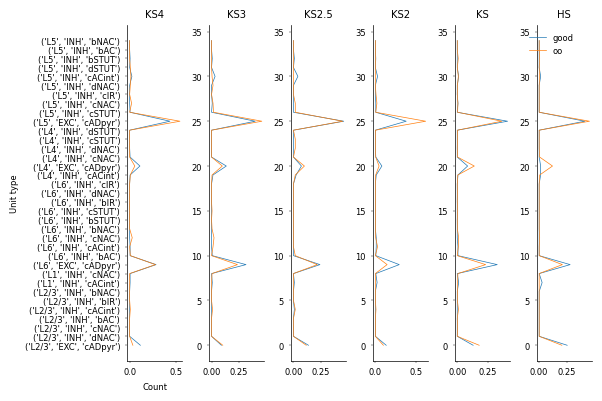

In [7]:
# plot raw count
fig, ax = plt.subplots(1, len(count_g.keys()), figsize=(6, 4))

xticks = np.arange(0, len(type_nm["type"]), 1)

# loop over spike sorter
for ix in range(len(count_g.keys())):

    ticks = np.arange(0, len(type_nm), 1)

    # aesthetics
    if ix == 0:
        ax[ix].set_yticks(xticks, type_nm["type"], rotation=0)
        ax[ix].set_xlabel("Count")
        ax[ix].set_ylabel("Unit type")

    # proportions
    # mixed: good
    ax[ix].plot(
        count_g[sorters[ix]]["count"].values
        / sum(count_g[sorters[ix]]["count"].values),
        xticks,
        label="good",
    )

    # poor: overmerger + oversplitter
    ax[ix].plot(
        count_oo[sorters[ix]]["count"].values
        / sum(count_oo[sorters[ix]]["count"].values),
        xticks,
        label="oo",
    )
    if ix == len(count_g.keys()) - 1:
        ax[ix].legend(frameon=False, loc="upper right", bbox_to_anchor=(0.8, 1))
    ax[ix].set_title(sorters[ix])

plt.tight_layout()

### Hypothesis testing: oo and good units unit type distributions are the same -> rejected

* hypothesis: oo and good units unit type distributions are the same.
* There are sample sizes smaller than 5, so Fisher-exact test of goodness of fit and not chi-square.
* the marginals of the resulting table must equal those of the observed table. 
* cons: computationally intensive, so we used fisher monte carlo, which was validated against fisher exact test for small contingency tables.
* results were validated against the implementation in R for a simple contingency table.

In [69]:
# create contingency tables
obs_df_k4 = get_obs(count_g["KS4"], count_oo["KS4"])
obs_df_k3 = get_obs(count_g["KS3"], count_oo["KS3"])
obs_df_k25 = get_obs(count_g["KS2.5"], count_oo["KS2.5"])
obs_df_k2 = get_obs(count_g["KS2"], count_oo["KS2"])
obs_df_ks = get_obs(count_g["KS"], count_oo["KS"])
obs_df_hs = get_obs(count_g["HS"], count_oo["HS"])

# (1m)
# test hypothesis
print("k4 p-value:", stats.fisher_monte_carlo(obs_df_k4.values, num_simulations=10000))
print("k3 p-value:", stats.fisher_monte_carlo(obs_df_k3.values, num_simulations=10000))
print(
    "k2.5 p-value:", stats.fisher_monte_carlo(obs_df_k25.values, num_simulations=10000)
)
print("k2 p-value:", stats.fisher_monte_carlo(obs_df_k2.values, num_simulations=10000))
print("ks p-value:", stats.fisher_monte_carlo(obs_df_ks.values, num_simulations=10000))
print("hs p-value:", stats.fisher_monte_carlo(obs_df_hs.values, num_simulations=10000))
print("example observations:", obs_df_hs)

k4 p-value: 0.0
k3 p-value: 0.0
k2.5 p-value: 0.0
k2 p-value: 0.0
ks p-value: 0.0
hs p-value: 0.0
example observations:     good   oo
0     19   46
1      0    0
2      0    0
3      0    0
4      0    0
5      0    0
6      0    0
7      2    0
8      0    0
9     21   47
10     0    0
11     0    0
12     0    1
13     0    0
14     0    0
15     0    0
16     0    0
17     0    0
18     0    0
19     1    1
20     1   27
21     0    1
22     0    0
23     0    0
24     0    0
25    31  102
26     0    0
27     0    0
28     0    0
29     0    0
30     1    1
31     0    0
32     0    1
33     0    0
34     0    0


# references

https://stackoverflow.com/questions/25368284/fishers-exact-test-for-bigger-than-2-by-2-contingency-table  
https://bytepawn.com/ab-testing-and-fishers-exact-test.html